In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import dft
import scipy.constants as scipy_cst
import tensorflow as tf

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle

In c:\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In c:\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quality rcparam was deprecated in Matplo

In [2]:
class Parameters :
    
    
    def __init__(self, N=220, nLayers=150):
        
        # distance variables are converted in km
        #--------------------------------- variables ------------------------------------------------------#

        # distance
        self.L = 1000e3
        # bandwidth - 1 GHz
        self.B = 2#1e9  

        #---------------------------------- physical constants --------------------------------------------#

        # power loss in dB
        self.a_dB = 0.2 
        # loss coefficient
        self.alpha = (1e-4)*np.log2(10)*self.a_dB
        # speed of light km/s
        self.c = 3e5
        # dispersion ps/(nm-km)
        self.D = 17*1e-12/(1e-9*1e03)
        #non-linearity coefficient - W^-1 km^-1
        self.gama = 1.27*1e-3
        # a constant factor
        self.nsp = 1
        # Planck constant - J.s
        self.h = scipy_cst.Planck
        # center wavelength - km
        self.lambda0 = 1.55e-9
        # center frequency
        self.f0 = self.c/self.lambda0    
        # dispersion coefficient
        self.beta2 = -(self.D*self.lambda0**2)/(2*np.pi*self.c)

        #---------------------------------- scale factors ------------------------------------------------#

        self.T0 = np.sqrt(np.abs(self.beta2*self.L)/2)
        self.P0 = 2/(self.gama*self.L)

        #----------------------------------- noise PSD ---------------------------------------------------#

        # physical noise 
        self.sigma02 = self.nsp*self.h*self.alpha*self.f0
        # normalized
        self.sigma2 = self.sigma02*self.L/(self.P0*self.T0) 

        #-------------------------------------------------------------------------------------------------#

        self.power = 6e-2
        self.l = 5
        self.nz = 500
        self.z = 1 #self.l/self.L

        #------------------------------------ time mesh --------------------------------------------------#

        # you have to choose this
        self.T = 20
        # you have to choose this
        self.N = N #2*10**2 #2**10
        self.dt = self.T/self.N
        self.t = np.linspace(-self.T/2, self.T/2, num=self.N)

        #------------------------------------ frequency mesh ---------------------------------------------#

        self.F = 1/self.dt
        self.df = 1/self.T
        self.f = np.fft.fftfreq(self.N, self.dt) #np.linspace(-self.F/2, self.F/2, num=self.N)
        self.omega = 2*np.pi*self.f

        #------------------------------------ bits to signal ---------------------------------------------#

        # size of the constellation
        self.M = 16
        # number of symbols (or sinc functions); test with s=1
        self.n = 3 
        # number of bits
        self.nb = np.log2(self.M)
        # probability of zero
        self.p =1/2
        #epsilon
        self.eps = self.alpha
        # Number of the Layers of the Generative nnet 
        self.nbrLayers = nLayers
        # Amplitude for AWGN
        self.A = 1
        self.s = 1
    
    def setN(self,n):
        self.N = n
        self.__init__(N=n)
    
    def setNbrLayers(self,N):
        self.nbrLayers = N
        self.__init__(nbrLayers=N)

In [3]:
class NNetGenerator :

    #-------------------------------------------------------------------------------------------------#

    def __init__(self, parameters):
        self.params = parameters

    #-------------------------------------------------------------------------------------------------#

    def H(self, f, z):
        """ Compute the channel transfer function.
        @param f : frequency vector.
        @param z : scalar.
        """

        omega = 2*np.pi*f
        return np.exp(1j*z*omega**2)
       
    #-------------------------------------------------------------------------------------------------#

    def nnet_gen(self,  X):
        """ Simulate a NNet by computing the V matrix (V is Y in the implementation).
            @param X : data.
        """
        # reshaping the input
        
        #print("[INFO] starting {nnet_gen}...")
        X = X.reshape((-1, 1))
        dz = self.params.z/self.params.nz

        np.set_printoptions(precision=2, suppress=True)  # for compact output

        D = dft(self.params.N, scale='sqrtn')
        #D = np.fft.fft(np.eye(self.params.N))
        #print("[INFO] {nnet_gen} computed D.")

        R = self.H(self.params.f,dz)
        #print("[INFO] {nnet_gen} computed R.")


        W = np.dot(D.conj().T , np.dot(np.diag(R),D))
        #print("[INFO] {nnet_gen} computed W.")

        # Deep Neural Network

        #print("[INFO] {nnet_gen} started generating the data...")

        for j in range(self.params.nbrLayers):

            # Linear transformation     
            X = np.dot(W, X)
            # Non-Linear transformation
            X = self.activation(X, dz)

        # Gaussian Noise 
        Z = self.addNoise(len(X), self.params.sigma02 , self.params.B, dz)
        # Output
        Y = np.squeeze(X + Z)

        return Y

    #-------------------------------------------------------------------------------------------------#


    def activation(self, x, dz):
        """ Computes the activation of a neuron.
            @param X : data.
        """
        return x*np.exp(1j*dz*np.absolute(x)**2)

    #-------------------------------------------------------------------------------------------------#


    def addNoise(self, n, sigma2, B, dz):
        """ Generate Gaussian noise. """
        Pn = sigma2 * B * dz

        Z = np.fft.fftshift(np.fft.ifft(np.random.normal(loc=0, scale=np.sqrt(Pn), size=(n, 1))))
        return Z
        
    #-------------------------------------------------------------------------------------------------#

In [4]:
class Channel :

    #-------------------------------------------------------------------------------------------------#

    def __init__(self):
        super()

    #-------------------------------------------------------------------------------------------------#

    def channel(self, t, q0t, z, sigma2, B) :
        # total noise power in B Hz and distance [0, z]
        a = sigma2*B*z 
        # get the f vector from t vector
        f = np.fft.fftfreq(t.size, 2*t[-1]/t.size)
        omega = 2*np.pi*f
        omega2 = omega**2
        # input in frequency
        q0f = np.fft.fft(q0t)
        #output in frequency
        hwz = np.exp(1j*z*omega2)
        # element-wise multiplication
        qzf = np.multiply(q0f,hwz) 
        #add Guassian noise in frequency, with correct variance
        N = len(f)
        qzf = qzf + np.random.normal(0, np.sqrt(a), qzf.shape)
        # back to time
        qzt = np.fft.ifft(qzf) 

        print("[channel] qzt :",qzt)
        print("[channel] qzf :",qzf)
        
        return qzt, qzf

In [5]:
class Transmitor :

    def __init__(self):
        super()


    #-------------------------------------------------------------------------------------------------#
    
    def source(self, N, p):
        """ Generates an N-bit sequence drawn from a Bernoulli stochastic process.
            @param N : Length of the bit sequence
            @param p : probability of 0
        """
        n=1
        return np.random.binomial(n, p, size=N)


    #-------------------------------------------------------------------------------------------------#

    def build_constellations(self, M):
    
        """ Builds a M-QAM constellation.
            @param M : Number of symbols.
        """
        
        # Sequential address from 0 to M-1 (1xM dimension)
        n = np.arange(0,M)
        #convert linear addresses to Gray code
        a = np.asarray([x^(x>>1) for x in n])
        #Dimension of K-Map - N x N matrix
        D = np.sqrt(M).astype(int) 
        # NxN gray coded matrix
        a = np.reshape(a,(D,D))
        # identify alternate rows
        oddRows=np.arange(start = 1, stop = D ,step=2) 
        
        # reshape to 1xM - Gray code walk on KMap
        nGray=np.reshape(a,(M)) 
        
        #element-wise quotient and remainder
        (x,y)=np.divmod(nGray,D) 
        # PAM Amplitudes 2d+1-D - real axis
        Ax=2*x+1-D 
        # PAM Amplitudes 2d+1-D - imag axis
        Ay=2*y+1-D 
        constellation = Ax+1j*Ay
        
        self.constellation = constellation

        return constellation


    #-------------------------------------------------------------------------------------------------#

    def bit_to_symb(self, b, cnt):
        """ Creates a mapping between bits sequences and symbols.
            @param b : N-bit sequence
            @param cnt : constellation
        """
        
        M = len(cnt)
        N = len(b)
        n = int(N/np.log2(M))
        #print("[bit_to_symb] n :",n)
        
        #dictionary of mapping
        mapping_dict = {}
        mapping_list = []
        for i in range(n):
            # bit sequence
            s = b[n*i:n*i+n]   
            s_str = ''.join(map(str, s)) # converts the bit array to string
            
            # avoids adding a 0 len string to the mapping
            if s_str != '' :
                symbol = cnt[i%M]
                mapping_dict[s_str] = symbol
                mapping_list.append((s_str,symbol))

        self.b2sMapping_dict = mapping_dict
        self.b2sMapping_list = mapping_list

        return mapping_dict

    #-------------------------------------------------------------------------------------------------#

In [6]:
class Modulator :

    #-------------------------------------------------------------------------------------------------#

    def __init__(self):
      super()

    #-------------------------------------------------------------------------------------------------#
    
    def mod(self, t,S, B):
        """ Modulate symbols data.
            @param t : time.
            @param s : sequence of symbols.
            @param B : Bandwidth.
        """

        # number of symbols
        Ns = len(S)
        # init
        q0t = 0
             
        for i in range(Ns):
            q0t = q0t + np.sqrt(B)*S[i]*np.sinc(B*t-i)
        
        norm = np.linalg.norm(q0t)
        q0t = q0t/norm
        norm = np.linalg.norm(q0t)

        #print("[Modulator] q0t = ", q0t)
        #print("[Modulator] Norm ||q0t||2 = ", norm)

        return q0t

    #-------------------------------------------------------------------------------------------------#


In [7]:
class Equalizer :

    #-------------------------------------------------------------------------------------------------#

    def __init__(self):
        super()

    #-------------------------------------------------------------------------------------------------#

    def equalize(self, t, qzt, z):
        
        # get the f vector from t vector
        f = np.fft.fftfreq(t.size, 2*t[-1]/t.size)
        # get the omega vector from f vector
        omega = 2*np.pi*f

        # compute omega² for h
        omega2 = omega**2

        # Channel transfer function
        hwz = np.exp(1j*z*omega2)
        hwz_1 = np.reciprocal(hwz)
        # input in frequency
        qzf = np.fft.fft(qzt)
        # output in frequency        
        qzfe = np.multiply(qzf,hwz_1)
        # back to time
        qzte = np.fft.ifft(qzfe)

        print("[Equalizer] qzte :",qzte)
        print("[Equalizer] qzfe :",qzfe)
        return qzte, qzfe

In [8]:
#-----------------------------------------------------------------------------------------#

def run(withPlot):

    # builds the constellation 
    constellation = transmitor.build_constellations(parameters.M) # 16-QAM

    # plots the constellation 
    #self.argand(constellation)
    
    # Bernoulli source, random bits sequence
    b = transmitor.source(parameters.N,parameters.p)

    # symbol sequence
    s = transmitor.bit_to_symb(b, constellation)

    # modulation
    q0t = modulator.mod(parameters.t,constellation, parameters.B)  
    q0f = np.fft.fft(q0t)
    
    
    if withPlot :
        fig1, (ax1, ax2) = plt.subplots(2, figsize = (15, 15))
        fig1.tight_layout(pad=7.0)


        ax1.plot(parameters.t, np.squeeze(q0t.real), 'b-')
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Re(q0t)")
        ax1.set_title("Modulation - Time plot - Re(q0t)")
        ####
        ax2.plot(parameters.f, np.squeeze(np.abs(q0f)), 'b-')
        ax2.set_xlabel("Freq")
        ax2.set_ylabel("Re(q0f)")
        ax2.set_title("Modulation - Freq plot - |q0f|")

    # channel - we take gaussian input
    q0t = parameters.A*np.exp(-parameters.t**2) 
    q0f = np.fft.fft(q0t)

    qzt, qzf = channel.channel(parameters.t, q0t, parameters.z, parameters.sigma02, parameters.B)

    # Equalization
    qzte, qzfe = equalizer.equalize(parameters.t, qzt, parameters.z)

    if withPlot :
        fig2, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, figsize = (15, 15))
        fig2.tight_layout(pad=7.0)

        ###
        ax1.plot(parameters.t, np.squeeze(q0t.real), 'b-')
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Re(q0t)")
        ax1.set_title("Modulation - Time plot - Re(q0t)")

        ###
        ax2.plot(parameters.f, np.squeeze(np.abs(q0f)), 'b-')
        ax2.set_xlabel("Freq")
        ax2.set_ylabel("Abs(q0f)")
        ax2.set_title("Modulation - Freq plot - |q0f|")

        ###        
        ax3.plot(parameters.t, np.squeeze(qzt.real), 'b-')
        ax3.set_xlabel("Time")
        ax3.set_ylabel("Re(qzt)")
        ax3.set_title("Channel - Time plot - Re(qzt)")

        ###
        ax4.plot(parameters.f, np.squeeze(np.abs(qzf)), 'b-')
        ax4.set_xlabel("Freq")
        ax4.set_ylabel("Abs(qzf)")
        ax4.set_title("Channel - Freq plot - |qzf|")

        ###
        ax5.plot(parameters.t, np.squeeze(qzte.real), 'b-')
        ax5.set_xlabel("Time")
        ax5.set_ylabel("Abs(qzf)")
        ax5.set_title("Equalization - Time plot - Re(qzte)")

        ###
        ax6.plot(parameters.f, np.squeeze(np.abs(qzfe)), 'b-')
        ax6.set_xlabel("Freq")
        ax6.set_ylabel("Abs(qzf)")
        ax6.set_title("Equalization - Freq plot - |qzfe|")

        plt.show()

#-----------------------------------------------------------------------------------------#

def generateData(X):
    
    return nnetGen.nnet_gen(X)

#-----------------------------------------------------------------------------------------#

# Generating the dataset
def generateDataset(nbrOfObservations, parameters):

    X = np.ndarray((parameters.N, nbrOfObservations), dtype=np.complex128)
    y = np.ndarray((parameters.N, nbrOfObservations), dtype=np.complex128)

    print("[INFO] Generating the dataset...")

    for i in tqdm(range(1,nbrOfObservations)):
        
        #source
        source = transmitor.source(parameters.N , parameters.p)

        # Constellation
        constellation = transmitor.build_constellations(parameters.M)

        # Bits to Symboles 
        bitsToSymbols = transmitor.bit_to_symb(source, constellation)
        # Modulation
        q0t = modulator.mod(parameters.t, constellation, parameters.B)
        X[:, i] = np.squeeze(q0t)

        # Neural Net Generator
        Y = nnetGen.nnet_gen(q0t)
        y[:, i] = Y

    print("[INFO] The dataset is ready now !")
    return X, y
#-----------------------------------------------------------------------------------------#

def createDataFrame(X,y) :
    X_ = np.column_stack((X.real,X.imag))
    y_ = np.column_stack((y.real,y.imag))
    data = np.column_stack((X_,y_))

    df = pd.DataFrame(data)
    print("df.shape : ",df.shape)
    df.to_csv("generatedData.csv")
    
    return df

#-----------------------------------------------------------------------------------------#

def allPlots(y_qzt, y_qzf, y_qzt_equalized_t, y_qzt_equalized_f, y_gen, y_gen_equalized_t, y_gen_equalized_f):
    fig2, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, figsize = (15, 15))
    fig2.tight_layout(pad=7.0)


    ###
    ax1.plot(parameters.t, np.squeeze(y_qzt.real), 'b-')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Abs(y_qzt)")
    ax1.set_title("Channel - Time plot - Re(y_qzt)")

    ###
    ax2.plot(parameters.f, np.squeeze(np.abs(y_qzf)), 'b-')
    ax2.set_xlabel("Freq")
    ax2.set_ylabel("Abs(y_qzf)")
    ax2.set_title("Equalization - Freq plot - |y_qzf|")

    ###
    ax3.plot(parameters.t, np.squeeze(np.abs(y_qzt_equalized_t)), 'b-')
    ax3.set_xlabel("Time")
    ax3.set_ylabel("Abs(y_qzt_equalized_t)")
    ax3.set_title("Equalization of normal input in the Channel - Time plot - |y_qzt_equalized_t|")

    ###
    ax4.plot(parameters.f, np.squeeze(np.abs(y_qzt_equalized_f)), 'b-')
    ax4.set_xlabel("Freq")
    ax4.set_ylabel("Abs(y_qzt_equalized_f)")
    ax4.set_title("Equalization of normal input in the Channel - Freq plot - |y_qzt_equalized_f|")

    ###
    ax5.plot(parameters.t, np.squeeze(np.absolute(y_gen)), 'b-')
    ax5.set_xlabel("Time")
    ax5.set_ylabel("Abs(y_gen)")
    ax5.set_title("NNetGen - Time plot - |y_gen|")

    ###
    ax6.plot(parameters.t, np.squeeze(np.abs(y_gen_equalized_t)), 'b-')
    ax6.set_xlabel("Time")
    ax6.set_ylabel("Abs(y_gen_equalized_t)")
    ax6.set_title("Equalization of NNetGen - Time plot - |y_gen_equalized_t|")

    ###        
    ax7.plot(parameters.f, np.squeeze(np.abs(y_gen_equalized_f)), 'b-')
    ax7.set_xlabel("Freq")
    ax7.set_ylabel("Abs(y_gen_equalized_t)")
    ax7.set_title("Equalization of NNetGen - Freq plot - |y_gen_equalized_f|")

    plt.show()

#-----------------------------------------------------------------------------------------#

In [9]:
N = 320
nL = 250

In [10]:
# Initialize parameters
parameters = Parameters(N, nL)
# Initialize the Transmitor
transmitor = Transmitor()
# Initialize the Transmitor
modulator = Modulator()
# Initialize the Channel
channel = Channel()
# Initialize the Equalizer
equalizer = Equalizer()
# Initialize the NNetGenerator
nnetGen = NNetGenerator(parameters)

## **Data preparation**

In [11]:
from numpy import load

In [12]:
X= load('./data/data gen/X_data.npy')
y= load('./data/data gen/y_data.npy')

In [13]:
X.shape

(138000, 800)

[channel] qzt : [-1.76935795e-03+2.16961518e-03j -1.71405199e-03+1.92126186e-03j
 -1.59970408e-03+1.44703232e-03j -1.41975302e-03+7.90064949e-04j
 -1.16651907e-03+1.06692412e-05j -8.33488880e-04-8.18567055e-04j
 -4.17881357e-04-1.61869344e-03j  7.68506160e-05-2.31087650e-03j
  6.38938543e-04-2.82294348e-03j  1.24696409e-03-3.09548609e-03j
  1.86953427e-03-3.08705580e-03j  2.46613164e-03-2.77805278e-03j
  2.98918633e-03-2.17300958e-03j  3.38728790e-03-1.30109029e-03j
  3.60932756e-03-2.14757022e-04j  3.60924898e-03+1.01331320e-03j
  3.35099984e-03+2.29485491e-03j  2.81322541e-03+3.53187228e-03j
  1.99323641e-03+4.62333539e-03j  9.09817719e-04+5.47226818e-03j
 -3.95479079e-04+5.99275940e-03j -1.85880454e-03+6.11643632e-03j
 -3.39634757e-03+5.79797840e-03j -4.90849159e-03+5.01931005e-03j
 -6.28558762e-03+3.79219363e-03j -7.41499805e-03+2.15903993e-03j
 -8.18894570e-03+1.91857250e-04j -8.51261889e-03-2.01063368e-03j
 -8.31194132e-03-4.32758920e-03j -7.54042011e-03-6.62211250e-03j
 -6.18453

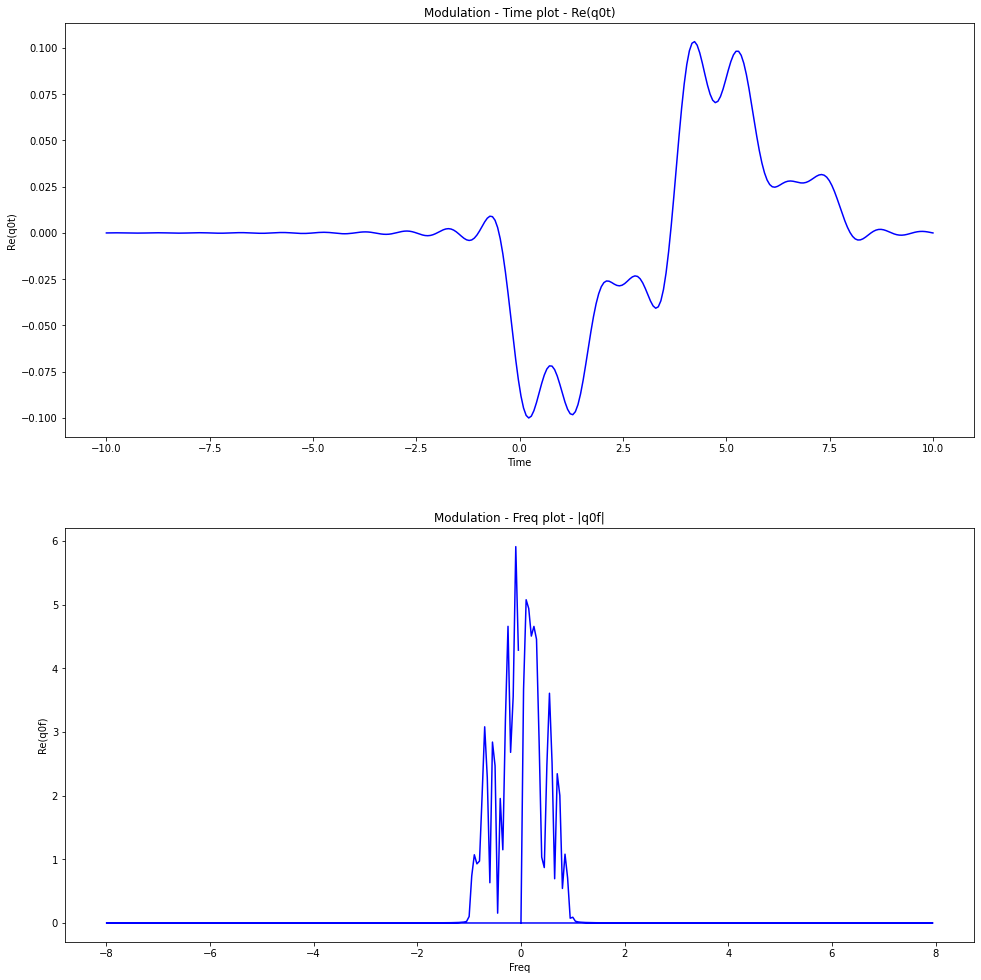

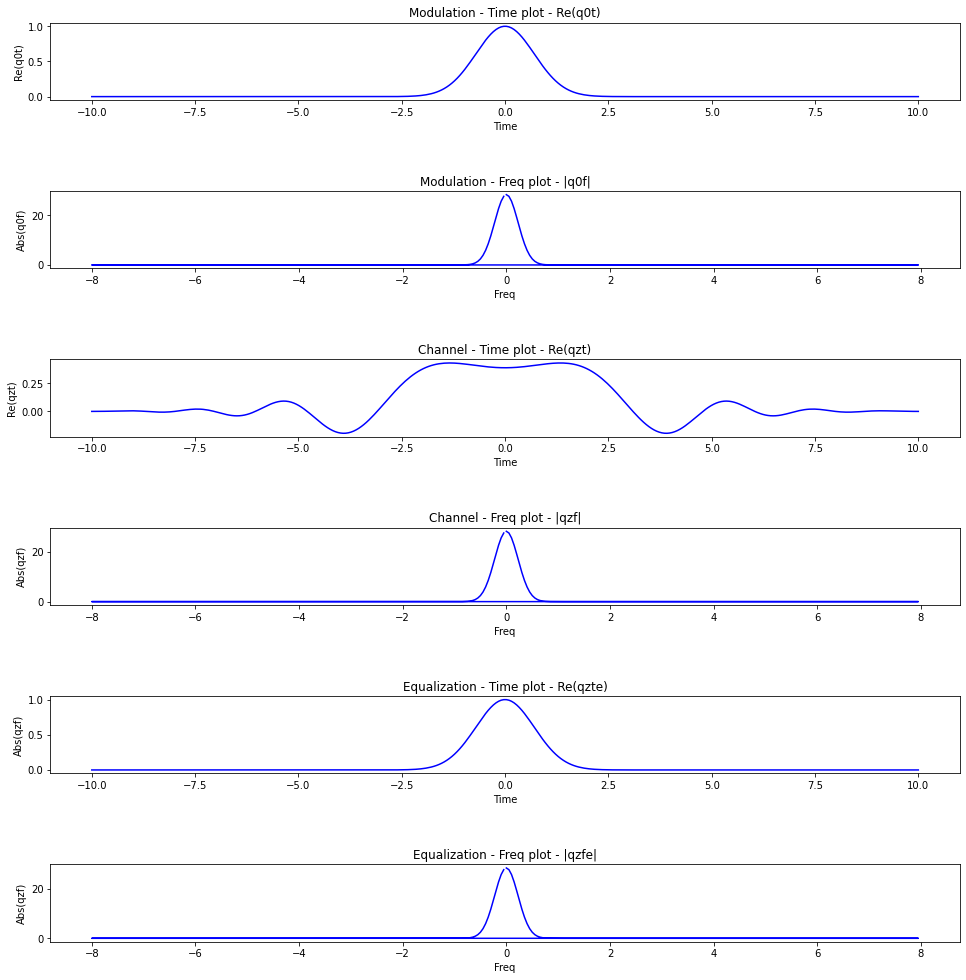

In [14]:
# run the project
withPlot = 1
run(withPlot)

In [18]:
#----------------------------------------------------------------------------#

def fromComplexToReal(vect_im):
  
    vect_real = []

    for i in tqdm(range(len(vect_im))) :
        tmp = []
        for j in range(len(vect_im[i])) :
            z = vect_im[i][j]
            tmp.append(z.real)
            tmp.append(z.imag)
        vect_real.append(tmp)

    vect_real = np.asarray(vect_real)
    print("{fromComplexToReal} vect_real.shape : ",vect_real.shape)

    return vect_real

#----------------------------------------------------------------------------#

def fromRealToComplex(vect_real):
  
    # init variables
    vect_im = []  

    # iterate over the vector
    for i in tqdm(range(len(vect_real))) :
        tmp = []
        j = 0

        # we can't use for loop with range() we have no control over the index
        while j < len(vect_real[i]) :

          # y = a+j*b
          im = vect_real[i][j] + 1j*vect_real[i][j+1]
          # we already processed two elements 
          j = j + 2
          # append the new element to the output array
          tmp.append(im)

        # matrix i*j
        vect_im.append(tmp)

    # to numpy
    vect_im = np.asarray(vect_im)
    print("{fromRealToComplex} vect_im.shape : ",vect_im.shape)

    return vect_im

#----------------------------------------------------------------------------#

def prepareDataFrame(X, y) :

    X_real = fromComplexToReal(X)
    y_real = fromComplexToReal(y)

    data = np.column_stack((X_real,y_real))

    df_ = pd.DataFrame(data)
    df_ = shuffle(df_)

    print("{prepareDataFrame} df_.shape : ",df_.shape)

    return df_

#----------------------------------------------------------------------------#

In [19]:
#df=pd.read_csv('gdrive/My Drive/DL_913/data/generatedData-2.csv')
df = prepareDataFrame(X, y)

  0%|                                                                             | 89/138000 [00:00<02:36, 881.22it/s]

{fromComplexToReal} vect_real.shape :  (138000, 1600)


100%|████████████████████████████████████████████████████████████████████████| 138000/138000 [01:51<00:00, 1241.20it/s]


{fromComplexToReal} vect_real.shape :  (138000, 1600)
{prepareDataFrame} df_.shape :  (138000, 3200)


In [20]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,3190,3191,3192,3193,3194,3195,3196,3197,3198,3199
78514,1.232387e-18,-1.717075e-17,0.000007,0.000021,0.000013,0.000041,0.000019,0.000061,0.000025,0.000079,...,0.001252,0.000234,0.001235,0.000076,0.001193,-0.000079,0.001129,-0.000227,0.001043,-0.000365
135947,1.232387e-18,-1.717075e-17,0.000007,0.000021,0.000013,0.000041,0.000019,0.000061,0.000025,0.000079,...,0.001252,0.000234,0.001235,0.000076,0.001193,-0.000079,0.001129,-0.000227,0.001043,-0.000365
25807,1.232387e-18,-1.717075e-17,0.000007,0.000021,0.000013,0.000041,0.000019,0.000061,0.000025,0.000079,...,0.001252,0.000234,0.001235,0.000076,0.001193,-0.000079,0.001129,-0.000227,0.001043,-0.000365
111800,1.232387e-18,-1.717075e-17,0.000007,0.000021,0.000013,0.000041,0.000019,0.000061,0.000025,0.000079,...,0.001252,0.000234,0.001235,0.000076,0.001193,-0.000079,0.001129,-0.000227,0.001043,-0.000365
31039,1.232387e-18,-1.717075e-17,0.000007,0.000021,0.000013,0.000041,0.000019,0.000061,0.000025,0.000079,...,0.001252,0.000234,0.001235,0.000076,0.001193,-0.000079,0.001129,-0.000227,0.001043,-0.000365


In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,119960,119961,119962,119963,119964,119965,119966,119967,119968,119969,119970,119971,119972,119973,119974,119975,119976,119977,119978,119979,119980,119981,119982,119983,119984,119985,119986,119987,119988,119989,119990,119991,119992,119993,119994,119995,119996,119997,119998,119999
71,0.0,0.0,0.000076,0.000158,0.000076,0.000158,0.000076,0.000158,0.000076,0.000158,0.000076,0.000158,0.000076,0.000158,0.000076,0.000158,0.000076,0.000158,0.000076,0.000158,0.000076,0.000158,0.000076,0.000158,0.000076,0.000158,0.000076,0.000158,0.000076,0.000158,0.000076,0.000158,0.000076,0.000158,0.000076,0.000158,0.000076,0.000158,0.000076,0.000158,...,0.005711,0.010499,0.005711,0.010499,0.005711,0.010499,0.005711,0.010499,0.005711,0.010499,0.005711,0.010499,0.005711,0.010499,0.005711,0.010499,0.005711,0.010499,0.005711,0.010499,0.005711,0.010499,0.005711,0.010499,0.005711,0.010499,0.005711,0.010499,0.005711,0.010499,0.005711,0.010499,0.005711,0.010499,0.005711,0.010499,0.005711,0.010499,0.005711,0.010499
272,0.0,0.0,0.028722,-0.043263,0.028722,-0.043263,0.028722,-0.043263,0.028722,-0.043263,0.028722,-0.043263,0.028722,-0.043263,0.028722,-0.043263,0.028722,-0.043263,0.028722,-0.043263,0.028722,-0.043263,0.028722,-0.043263,0.028722,-0.043263,0.028722,-0.043263,0.028722,-0.043263,0.028722,-0.043263,0.028722,-0.043263,0.028722,-0.043263,0.028722,-0.043263,0.028722,-0.043263,...,0.040615,-0.007862,0.040615,-0.007862,0.040615,-0.007862,0.040615,-0.007862,0.040615,-0.007862,0.040615,-0.007862,0.040615,-0.007862,0.040615,-0.007862,0.040615,-0.007862,0.040615,-0.007862,0.040615,-0.007862,0.040615,-0.007862,0.040615,-0.007862,0.040615,-0.007862,0.040615,-0.007862,0.040615,-0.007862,0.040615,-0.007862,0.040615,-0.007862,0.040615,-0.007862,0.040615,-0.007862
294,0.0,0.0,-0.001158,0.002914,-0.001158,0.002914,-0.001158,0.002914,-0.001158,0.002914,-0.001158,0.002914,-0.001158,0.002914,-0.001158,0.002914,-0.001158,0.002914,-0.001158,0.002914,-0.001158,0.002914,-0.001158,0.002914,-0.001158,0.002914,-0.001158,0.002914,-0.001158,0.002914,-0.001158,0.002914,-0.001158,0.002914,-0.001158,0.002914,-0.001158,0.002914,-0.001158,0.002914,...,-0.005149,-0.021867,-0.005149,-0.021867,-0.005149,-0.021867,-0.005149,-0.021867,-0.005149,-0.021867,-0.005149,-0.021867,-0.005149,-0.021867,-0.005149,-0.021867,-0.005149,-0.021867,-0.005149,-0.021867,-0.005149,-0.021867,-0.005149,-0.021867,-0.005149,-0.021867,-0.005149,-0.021867,-0.005149,-0.021867,-0.005149,-0.021867,-0.005149,-0.021867,-0.005149,-0.021867,-0.005149,-0.021867,-0.005149,-0.021867
132,0.0,0.0,0.002317,0.002897,0.002317,0.002897,0.002317,0.002897,0.002317,0.002897,0.002317,0.002897,0.002317,0.002897,0.002317,0.002897,0.002317,0.002897,0.002317,0.002897,0.002317,0.002897,0.002317,0.002897,0.002317,0.002897,0.002317,0.002897,0.002317,0.002897,0.002317,0.002897,0.002317,0.002897,0.002317,0.002897,0.002317,0.002897,0.002317,0.002897,...,0.000724,-0.015034,0.000724,-0.015034,0.000724,-0.015034,0.000724,-0.015034,0.000724,-0.015034,0.000724,-0.015034,0.000724,-0.015034,0.000724,-0.015034,0.000724,-0.015034,0.000724,-0.015034,0.000724,-0.015034,0.000724,-0.015034,0.000724,-0.015034,0.000724,-0.015034,0.000724,-0.015034,0.000724,-0.015034,0.000724,-0.015034,0.000724,-0.015034,0.000724,-0.015034,0.000724,-0.015034
154,0.0,0.0,-0.021124,-0.022506,-0.021124,-0.022506,-0.021124,-0.022506,-0.021124,-0.022506,-0.021124,-0.022506,-0.021124,-0.022506,-0.021124,-0.022506,-0.021124,-0.022506,-0.021124,-0.022506,-0.021124,-0.022506,-0.021124,-0.022506,-0.021124,-0.022506,-0.021124,-0.022506,-0.021124,-0.022506,-0.021124,-0.022506,-0.021124,-0.022506,-0.021124,-0.022506,-0.021124,-0.022506,-0.021124,-0.022506,...,-0.039496,-0.022928,-0.039496,-0.022928,-0.039496,-0.022928,-0.039496,-0.022928,-0.039496,-0.022928,-0.039496,-0.022928,-0.039496,-0.022928,-0.039496,-0.022928,-0.039496,-0.022928,-0.039496,-0.022928,-0.039496,-0.022928,

In [21]:
df.shape

(138000, 3200)

In [22]:
scaler = preprocessing.MinMaxScaler()
df = scaler.fit_transform(df)

In [23]:
df.shape[1]

3200

In [60]:
from numpy import save
save("L:/data_scaled.npy", df)

### **Train & Test Split**

In [24]:
def prepareTrainAndTestData(df, withReshape):

  #df = df.set_index('Attribute',inplace=True)
  

  N_samples = df.shape[0]
  N_features = df.shape[1]//2
  N_cols = df.shape[1]
  
  if type(df) != np.ndarray :
    print("[INFO] - {prepareTrainAndTestData} converting from pandas to numpy...")
    df_np = df.to_numpy()
    X = df_np[:N_samples,0:N_features]
    y = df_np[:N_samples,N_features:N_cols]
  else :
    X = df[:N_samples,0:N_features]
    y = df[:N_samples,N_features:N_cols]
  
  N_features = len(X[0])

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  N_samples_train = len(X_train)
  N_samples_test = len(X_test)

  if withReshape :
    X_train = X_train.reshape(N_samples_train, N_features, 1)
    X_test = X_test.reshape(N_samples_test, N_features, 1)
    y_train = y_train.reshape(N_samples_train, N_features, 1)
    y_test = y_test.reshape(N_samples_test, N_features, 1)
    
  print(X.shape)
  print(y.shape)
  print(X_train.shape)
  print(y_train.shape)
  print(X_test.shape)
  print(y_test.shape)

  return X_train, X_test, y_train, y_test

In [25]:
withReshape = True
X_train, X_test, y_train, y_test = prepareTrainAndTestData(df, withReshape)

(138000, 1600)
(138000, 1600)
(110400, 1600, 1)
(110400, 1600, 1)
(27600, 1600, 1)
(27600, 1600, 1)


# **Model Training & Testing**

In [104]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Conv1D, Conv2D, Dense, MaxPooling1D, MaxPooling2D, Flatten, Dropout, LeakyReLU
#from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import History 
from keras.utils.vis_utils import plot_model

from tensorflow.keras import Sequential


from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K

In [95]:
import keras
#from keras.models import Sequential

In [96]:
#-----------------------------------------------------------------------------------------------------#

def train(model, X_train, X_test, y_train, y_test, Nepochs, batchSize) :
  # Fiting the model
  model.fit( X_train, y_train, 
            batch_size = batchSize, 
            epochs = Nepochs, 
            verbose = 1, 
            validation_data =(X_test, y_test), 
            callbacks =[history])
  
  return model

#-----------------------------------------------------------------------------------------------------#

def test_model(model, X_test, y_test, history, index_pred) :
    with_eval = False
    with_error_plots = False
    y_pred = evaluate(model, X_test, y_test, history, index_pred, with_eval, with_error_plots)
    return y_pred

#-----------------------------------------------------------------------------------------------------#


def evaluate(model, X_test, y_test, history, index_pred, with_eval, with_error_plots):

    # evaluating and printing results 
    if with_eval :
        score = model.evaluate(X_test, y_test, verbose = 0) 
        print('Test loss:', score[0]) 
        print('Test accuracy:', score[1]) 

    # Plots

    if with_error_plots : 
        plt.plot(history.history['mean_squared_error'])
        plt.title("mean_squared_error")
        plt.show()
        plt.plot(history.history['mean_absolute_error'])
        plt.title("mean_absolute_error")
        plt.show()
        plt.plot(history.history['mean_absolute_percentage_error']) 
        plt.title("mean_absolute_percentage_error")
        plt.show()
        plt.plot(history.history['cosine_proximity'])
        plt.title("cosine_proximity")
        plt.show()
        plt.plot(history.history['msle'])
        plt.title("msle")
        plt.show()

    # prediction on one element
    X = X_test[index_pred]
    y_pred = model.predict(X)
    print("X_test.shape : ",X_test.shape)
    print("y_test.shape : ",y_test.shape)
    print("X.shape : ",X.shape)
    print("y_pred.shape : ",y_pred.shape)
    print("After reshaping...")
    X = X.reshape(-1,1)
    y_pred = y_pred.reshape(-1,1)
    print("X.shape : ",X.shape)
    print("y_pred.shape : ",y_pred.shape)

    X_im = fromRealToComplex(X.T)
    y_im = fromRealToComplex(y_pred.T)

    y_qzt, y_qzf = channel.channel(parameters.t, X_im, parameters.z, parameters.sigma02, parameters.B)
    y_gen_equalized_t, y_gen_equalized_f = equalizer.equalize(parameters.t, y_im, parameters.z)
    y_qzt_equalized_t, y_qzt_equalized_f = equalizer.equalize(parameters.t, y_qzt, parameters.z)

    allPlots(y_qzt, y_qzf, y_qzt_equalized_t, y_qzt_equalized_f, y_im, y_gen_equalized_t, y_gen_equalized_f)

    """
    #Xf = np.fft.fftshift(X_)
    #Yf = np.fft.fftshift(y_pred)

    X_im = fromRealToComplex(X_.T)
    y_im = fromRealToComplex(y_pred.T)

    Xf = np.fft.fftshift(X_im)
    Yf = np.fft.fftshift(y_im)

    # Plots
    f = np.fft.fftfreq(parameters.N, parameters.dt)
    fig3, (ax5) = plt.subplots(1, figsize = (10, 10))
    fig3.tight_layout(pad=7.0)

    # Xf
    ax5.plot(f, np.absolute(Xf.T), 'b-', label='nnet')
    ax5.set_xlabel("Time")
    ax5.set_ylabel("Abs(y_gen)")
    ax5.set_title("NNetGen - Time plot - |y_gen|")

    # Yf
    ax5.plot(f, np.squeeze(np.absolute(Yf.T)), 'r--', label='nnet')
    ax5.set_xlabel("Freq")
    ax5.set_ylabel("Abs(y_gen)")
    ax5.set_title("NNetGen - Freq plot - |y_gen|")
    """

    return y_pred

#-----------------------------------------------------------------------------------------------------#

def all_evals(model, index_pred):

    with_error_plots = False
    with_eval = False
    y_pred = evaluate(model, X_test, y_test, history, index_pred, with_eval, with_error_plots)

    X_test_im = goBackToComplexVector(X_test[index_pred])
    y_test_im = goBackToComplexVector(y_test[index_pred])
    y_pred_im = goBackToComplexVector(y_pred)

    plotOne(X_test_im)
    plotTwo(X_test_im, y_pred_im)
    plotTwo(y_test_im, y_pred_im)


#-----------------------------------------------------------------------------------------------------#

def plotResults(X, y_pred):

    y_pred_im = fromRealToComplex(y_pred.T).T
    X = fromRealToComplex(X.T).T

    Xf = np.fft.fftshift(X)
    Yf = np.fft.fftshift(y_pred_im)

    fig3, (ax5) = plt.subplots(1, figsize = (10, 10))
    fig3.tight_layout(pad=7.0)

    ###
    ax5.plot(parameters.f, np.absolute(Xf), 'b-', label='nnet')
    ax5.set_xlabel("Time")
    ax5.set_ylabel("Abs(y_gen)")
    ax5.set_title("NNetGen - Time plot - |y_gen|")

    ###
    ax5.plot(parameters.f, np.squeeze(np.absolute(Yf)), 'r-', label='nnet')
    ax5.set_xlabel("Freq")
    ax5.set_ylabel("Abs(y_gen)")
    ax5.set_title("NNetGen - Freq plot - |y_gen|")

#-----------------------------------------------------------------------------------------------------#

In [198]:
history = History()
batch_size = 16
N_features = len(X_train[0])
N_samples = len(X_train)
N_output = len(y_train[0])
inputShape = (batch_size, N_features, 1)#(N_samples, batch_size, N_features) 
inputShape

(16, 1600, 1)

In [199]:
X_train.shape

(110400, 1600, 1)

In [200]:
type(X_train)

numpy.ndarray

## **Dense (MLP)**

In [201]:
def my_activation(x):
    """ Computes the activation of a neuron.
        @param X : data.
    """
    dz = parameters.z/parameters.nz

    return x*K.exp(dz*K.abs(x)**2)
        
def create_MLP():

    # custom activation function
    #get_custom_objects().update({'my_activation': Activation(my_activation)})
    # Model
    model_dense= tf.keras.Sequential()

    # Input layer

    #model_dense.add(Input(shape=input_shape))
    #model_dense.add(Dense(100, input_shape=(N_features,1), activation='relu'))
    model_dense.add(Dense(128, kernel_initializer='normal', input_shape=X_train.shape[1:], activation='sigmoid'))
    #model_dense.add(Dense(16, kernel_initializer='normal', input_shape=X_train.shape[1:]))
    #model_dense.add(Activation(my_activation, name='SpecialActivation'))
    model_dense.add(Dropout(0.3))


    # Fully connected layers

    model_dense.add(Dense(258, kernel_initializer='normal', activation='relu'))
    model_dense.add(Dropout(0.2))

    # Convolution layers

    """
    model_dense.add(Conv1D(filters=258, kernel_size=1 ,strides=1, input_shape=X_train.shape[1:], kernel_initializer= 'uniform')) 
    model_dense.add(LeakyReLU())
    model_dense.add(Dropout(0.25))

    model_dense.add(Conv1D(filters=64, kernel_size=1 ,strides=1,  kernel_initializer= 'uniform', activation='sigmoid'))
    model_dense.add(Dropout(0.4))
   
    
    model_dense.add(Conv1D(filters=32, kernel_size=1 ,strides=1,  kernel_initializer= 'uniform')) 
    model_dense.add(LeakyReLU())
    model_dense.add(Dropout(0.2))
    """
    # Fully connected layers
    model_dense.add(Dense(64, kernel_initializer='normal', activation='sigmoid'))
    model_dense.add(Dropout(0.25))

    model_dense.add(Dense(32, kernel_initializer='normal'))
    model_dense.add(LeakyReLU())


    # Output layer
    model_dense.add(Dense(1))

    # Compile
    #model_dense.compile(loss='mean_squared_error', optimizer='adam', metrics =['accuracy', 'mse'])
    model_dense.compile(loss='mean_squared_error', 
                      optimizer='adam', 
                      metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity', 'msle'])
  
    return model_dense

In [202]:
model_dense = create_MLP()

In [203]:
#plot_model(model_dense, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [204]:
model_dense.output_shape

(None, 1600, 1)

In [205]:
model_dense.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 1600, 128)         256       
_________________________________________________________________
dropout_56 (Dropout)         (None, 1600, 128)         0         
_________________________________________________________________
dense_67 (Dense)             (None, 1600, 258)         33282     
_________________________________________________________________
dropout_57 (Dropout)         (None, 1600, 258)         0         
_________________________________________________________________
dense_68 (Dense)             (None, 1600, 64)          16576     
_________________________________________________________________
dropout_58 (Dropout)         (None, 1600, 64)          0         
_________________________________________________________________
dense_69 (Dense)             (None, 1600, 32)        

In [206]:
X_train.shape

(110400, 1600, 1)

In [207]:
batch_size = 16
epochs = 5

In [ ]:
# Fiting the model
model_dense = train(model_dense, X_train, X_test, y_train, y_test, epochs , batch_size)

Epoch 1/5
  24/6900 [..............................] - ETA: 1:22:28 - loss: 0.2804 - mean_squared_error: 0.2804 - mean_absolute_error: 0.5000 - mean_absolute_percentage_error: 241416360.6667 - cosine_proximity: 0.4988 - msle: 0.1360

In [ ]:
# testing the model
index_pred = 269
y_pred = test_model(model_dense, X_test, y_test, history, index_pred)

## **CNN**

In [ ]:
withReshape = True
X_train, X_test, y_train, y_test = prepareTrainAndTestData(df, withReshape)

(1000, 2000)
(1000, 2000)
(800, 2000, 1)
(800, 2000, 1)
(200, 2000, 1)
(200, 2000, 1)


In [ ]:
X_train.shape[1:]

(2000, 1)

### **CNN-1D**

In [ ]:
#-----------------------------------------------------------------------------------------------------#

def create_CNN1D():
    # Model
  model_cnn1D = Sequential()

  # Input layer

  #model_cnn1D.add(Input(shape=input_shape))
  model_cnn1D.add(Dense(256, input_shape=X_train.shape[1:], activation='relu'))
  model_cnn1D.add(Dropout(0.25))

  # Convolution layers

  model_cnn1D.add(Conv1D(filters=64, kernel_size=1 ,strides=1, input_shape=X_train.shape[1:], kernel_initializer= 'uniform')) 
  model_cnn1D.add(LeakyReLU())
  model_cnn1D.add(Dropout(0.25))

  model_cnn1D.add(Conv1D(filters=32, kernel_size=1 ,strides=1,  kernel_initializer= 'uniform'))
  model_cnn1D.add(LeakyReLU())
  model_cnn1D.add(Dropout(0.4))

  model_cnn1D.add(Conv1D(filters=64, kernel_size=1 ,strides=1,  kernel_initializer= 'uniform')) 
  model_cnn1D.add(LeakyReLU())
  model_cnn1D.add(Dropout(0.2))

  # Fully connected layers
  model_cnn1D.add(Dense(128,  activation='relu'))
  model_cnn1D.add(Dropout(0.2))
  model_cnn1D.add(Dense(256,  activation='relu'))
  model_cnn1D.add(Dropout(0.4))
  model_cnn1D.add(Dense(128,  activation='relu'))
  model_cnn1D.add(Dropout(0.2))
  # Output layer
  model_cnn1D.add(Dense(1))

  # Compile
  model_cnn1D.compile(loss='mean_squared_error', 
                      optimizer='adam', 
                      metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity', 'msle'])

  return model_cnn1D


#-----------------------------------------------------------------------------------------------------#

In [ ]:
model_cnn1D = create_CNN1D()

In [ ]:
model_cnn1D.output_shape

(None, 640, 1)

In [ ]:
model_cnn1D.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 640, 256)          512       
_________________________________________________________________
dropout_62 (Dropout)         (None, 640, 256)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 640, 64)           16448     
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 640, 64)           0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 640, 64)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 640, 32)           2080      
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 640, 32)         

In [ ]:
Nepochs = 28
batch_size = 16
model_cnn1D = train(model_cnn1D, X_train, X_test, y_train, y_test, Nepochs, batch_size)

Epoch 1/28
1500/1500 [==============================] - 14s 9ms/step - loss: 0.2426 - mean_squared_error: 0.2426 - mean_absolute_error: 0.4680 - mean_absolute_percentage_error: 225144631.9412 - cosine_proximity: 0.5045 - msle: 0.1187 - val_loss: 0.2315 - val_mean_squared_error: 0.2315 - val_mean_absolute_error: 0.4638 - val_mean_absolute_percentage_error: 232178880.0000 - val_cosine_proximity: 0.5079 - val_msle: 0.1143
Epoch 2/28
1500/1500 [==============================] - 13s 9ms/step - loss: 0.2324 - mean_squared_error: 0.2324 - mean_absolute_error: 0.4636 - mean_absolute_percentage_error: 231171317.9374 - cosine_proximity: 0.5079 - msle: 0.1145 - val_loss: 0.2315 - val_mean_squared_error: 0.2315 - val_mean_absolute_error: 0.4630 - val_mean_absolute_percentage_error: 230153792.0000 - val_cosine_proximity: 0.5079 - val_msle: 0.1140
Epoch 3/28
1500/1500 [==============================] - 13s 9ms/step - loss: 0.2320 - mean_squared_error: 0.2320 - mean_absolute_error: 0.4635 - mean_abso

#### **Prediction with CNN-1D**

X_test.shape :  (6000, 640, 1)
y_test.shape :  (6000, 640, 1)
X.shape :  (640, 1)
y_pred.shape :  (640, 1, 1)
After reshaping...
X.shape :  (640, 1)
y_pred.shape :  (640, 1)
{fromRealToComplex} vect_im.shape :  (1, 320)
{fromRealToComplex} vect_im.shape :  (1, 320)
[channel] qzt : [[ 0.46927867-0.56914292j -0.24650065-0.25185129j -0.02513428+0.10792871j
  -0.19471949+0.58599232j -0.0122321 +0.59183876j  0.42402895+0.65226244j
   0.55863488+0.49557274j  0.3911976 +0.99970593j  0.39911012+1.13480592j
   0.77265375+0.86497088j  0.61326869+1.01024162j  0.38939866+0.58615j
   0.56990377+0.61519382j  0.32749172+0.7484868j   0.37280078+0.65604303j
   0.27688646+0.25264634j  0.26406136+0.20368612j -0.45891932+0.36887786j
  -0.02133668+0.48481174j  0.23486433+0.90968882j  0.50482799+0.86919563j
   0.67433681+0.75001606j  0.78892468+0.64132216j  0.54999475+1.17755007j
   0.61971067+0.85028243j  1.18283923+0.97193465j  1.05315882+0.68754112j
   0.84669003+0.32225595j  0.95494771+0.22016701j  0.66

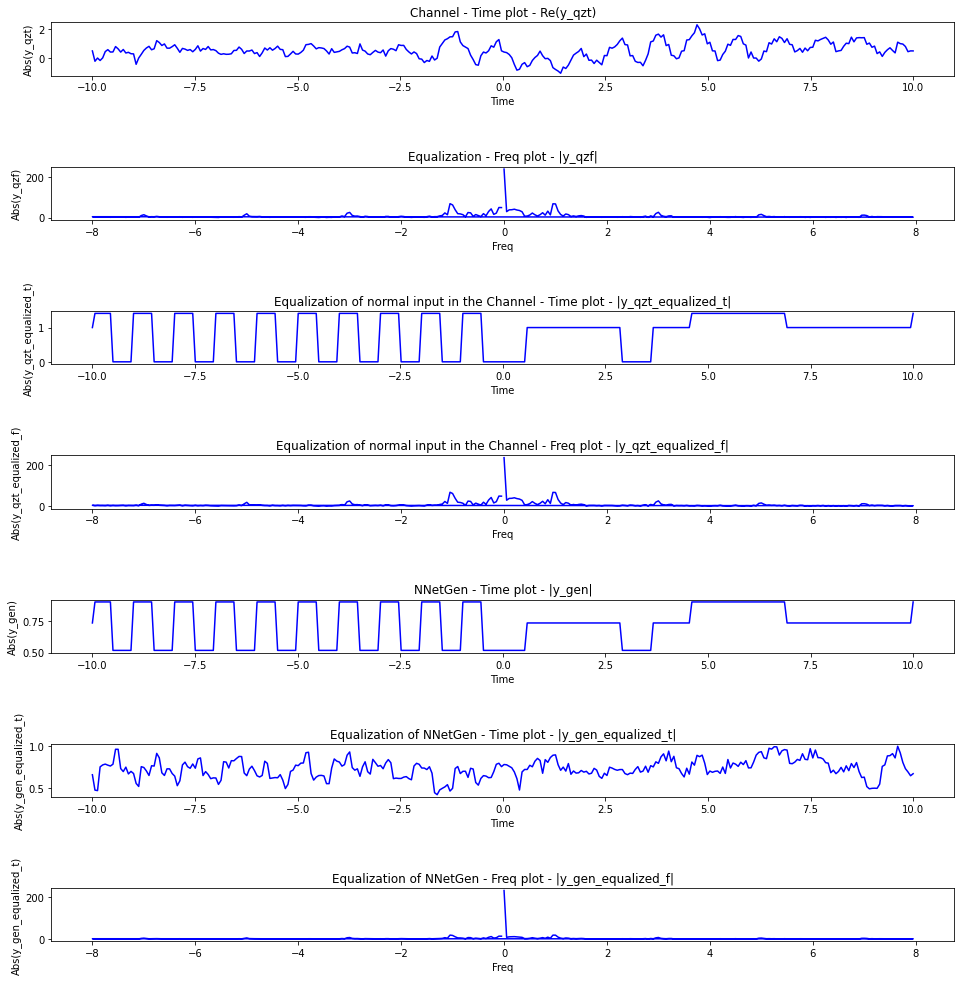

In [ ]:
index_pred = 21
y_pred_cnn1d = test_model(model_cnn1D, X_test, y_test, history, index_pred)

### **CNN-2D**

In [ ]:
model_cnn2D = Sequential()

# Input layer
model_cnn2D.add(Dense(10, input_dim=len(X_train[0]), activation='relu'))

# Convolution layers

model_cnn2D.add(Conv2D(32, kernel_size =(5, 5), strides =(1, 1))) 
model_cnn2D.add(MaxPooling2D(pool_size =(2, 2), strides =(2, 2)))
model_cnn2D.add(LeakyReLU())

model_cnn2D.add(Conv2D(64, (5, 5))) 
model_cnn2D.add(MaxPooling2D(pool_size =(2, 2)))
model_cnn2D.add(LeakyReLU())
model_cnn2D.add(Flatten()) 

# Fully connected layers
model_cnn2D.add(Dense(10, input_dim=2, activation='relu'))
model_cnn2D.add(Dense(10, input_dim=2, activation='relu'))

# Output layer
model_cnn2D.add(Dense(10, input_dim=2))

# Compile
model_cnn2D.compile(loss='mse', optimizer='adam', metrics =['accuracy', 'mse', 'r2'])

# **Save the model**

In [ ]:
from google.colab import files

In [ ]:
model_json = model_cnn1D.to_json()

In [ ]:
with open("model.json","w") as json_file:
     json_file.write(model_json)

In [ ]:
files.download("model.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
ckpt = tf.train.Checkpoint(optimizer='adam', net=model_cnn1D)
manager = tf.train.CheckpointManager(ckpt, "./tf_ckpts", max_to_keep=3)

# ----------------------------
# -----  Train and Save  -----
# ----------------------------

ckpt.restore(manager.latest_checkpoint)

save_path = manager.save()

In [ ]:
#Dump the model
with open('model_cnn1D.pickle','wb') as modelFile:
     pickle.dump(model_cnn1D,modelFile)

In [ ]:
files.download("model_cnn1D.json")